Model using all subjects' MRI images --> complete and balanced dataset. 

> *Remark: training and validation sets may contain images from the same subject (but not the same image)*



## SET UP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install load_dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, losses

from dotenv import load_dotenv

load_dotenv()

True

In [4]:
def get_datasets(data_dir_path, batch_size, img_width, img_height):
  data_dir = pathlib.Path(data_dir_path)

  train_ds = keras.utils.image_dataset_from_directory(
      directory = data_dir,
      subset="training",
      batch_size=batch_size,
      image_size=(img_height, img_width),
      validation_split=0.3,
      seed=123,
      label_mode='categorical'
      )

  validation_ds = keras.utils.image_dataset_from_directory(
      directory=data_dir,
      subset="validation",
      batch_size=batch_size,
      image_size=(img_height, img_width),
      validation_split=0.3,
      seed=123,
      label_mode='categorical')
  
  return train_ds, validation_ds

https://www.tensorflow.org/tutorials/images/classification?hl=es-419#configure_the_dataset_for_performance

In [5]:
def improve_performance(train_ds, validation_ds):
  # Caching and Prefetching

  AUTOTUNE = tf.data.AUTOTUNE
  
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, validation_ds

In [6]:
def showEvolution(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.title(str(title+" Loss"))
  plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.title(str(title+" Accuracy"))
  plt.show()

# Creating the model

### Basic EfficientNetB7


In [7]:
def EfficientNetB7_model(batch_size, img_width, img_height, epochs, num_classes, data_dir_path):
  
  # create the base pre-trained model:
  #   include_top=False allows feature extraction by removing the last dense layer
  base_model = EfficientNetB7(
      include_top=False,
      weights='imagenet',
      input_tensor=None,
      input_shape=None,
      pooling='avg',
      classes=1000,
      classifier_activation="softmax"
  )

  # add a global spatial average pooling layer
  x = base_model.output

  # and a logistic layer 
  predictions = layers.Dense(num_classes, activation='softmax')(x)

  # this is the model we will train
  model = Model(base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = False

  # compile the model (should be done *after* setting layers to non-trainable)
  opt = Adam(lr=1e-4, decay=1e-4 / epochs)
  model.compile(optimizer=opt,
                loss=losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    name='categorical_crossentropy'),
                metrics=['accuracy'])

  model.summary()

  train_ds, validation_ds = get_datasets(data_dir_path, batch_size, img_width, img_height)

  class_names = train_ds.class_names

  train_ds, validation_ds = improve_performance(train_ds, validation_ds)

  epochs = epochs

  # train the model on the new data for a few epochs
  history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, verbose = 1)

  return model, history, class_names

# MAIN PROGRAM

In [8]:
DATA_REPEATED_SUBJECT_CN_AD_PATH = os.getenv('DATA_REPEATED_SUBJECT_CN_AD_PATH')
DATA_REPEATED_SUBJECT_CN_MCI_AD_PATH = os.getenv('DATA_REPEATED_SUBJECT_CN_MCI_AD_PATH')
CLASSES_CN_AD = 2
CLASSES_CN_MCI_AD = 3

BATCH_SIZE = 16
IMG_SIZE = 224
EPOCHS = 70

### Training

In [9]:
EfficientNetB7_2_classes_model, EfficientNetB7_2_classes_history, class_2_names  = EfficientNetB7_model(BATCH_SIZE, IMG_SIZE, IMG_SIZE, EPOCHS, CLASSES_CN_AD, DATA_REPEATED_SUBJECT_CN_AD_PATH)
print(class_2_names)

EfficientNetB7_3_classes_model, EfficientNetB7_3_classes_history, class_3_names  = EfficientNetB7_model(BATCH_SIZE, IMG_SIZE, IMG_SIZE, EPOCHS, CLASSES_CN_MCI_AD, DATA_REPEATED_SUBJECT_CN_MCI_AD_PATH)
print(class_3_names)

258076736/258076736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ivation)                       192)                                                              
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, None, None,   0          ['block2a_expand_activation[0][0]
 g2D)                           192)                             ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, None, None,   1728       ['block2a_dwconv_pad[0][0]']     
 D)                             192)                                                              
                                                                                                  
 block2a_bn (BatchNormalization  (None, None, None,   768        ['block2a_dwconv[0][0]']         
 )                              192)                                                              
          

### Results

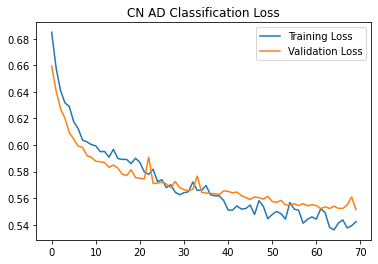

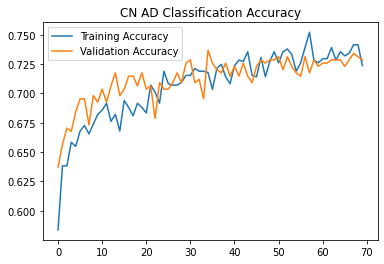

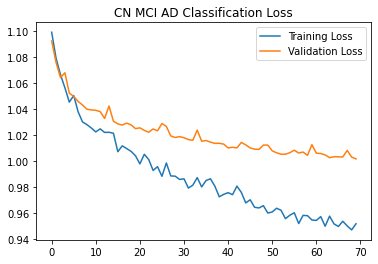

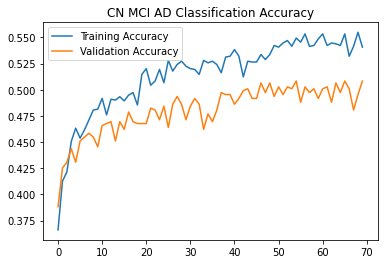

In [10]:
showEvolution(EfficientNetB7_2_classes_history, "CN AD Classification")
showEvolution(EfficientNetB7_3_classes_history, "CN MCI AD Classification")